In [1]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
import matplotlib.pyplot as plt
from elephant.gpfa import GPFA

In [2]:
def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float
        Initial values in three dimensional space.
    angular_frequency : float
        Angular frequency in 1/ms.

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))


def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,sigma=10, rho=28, beta=2.667, tau=1e3):
    """

    Parameters
    ----------
    dt :
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0, z0 : float
        Initial values in three dimensional space
    sigma, rho, beta : float
        Parameters defining the lorenz attractor
    tau : characteristic timescale in ms

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (3, num_steps) np.ndarray
        Integrated three-dimensional trajectory (x, y, z) of the Lorenz attractor
    """
    def _lorenz_ode(point_of_interest, timepoint, sigma, rho, beta, tau):
        """
        Fit the model with `spiketrains` data and apply the dimensionality
        reduction on `spiketrains`.

        Parameters
        ----------
        point_of_interest : tuple
            Tupel containing coordinates (x,y,z) in three dimensional space.
        timepoint : a point of interest in time
        dt :
            Integration time step in ms.
        num_steps : int
            Number of integration steps -> max_time = dt*(num_steps-1).
        sigma, rho, beta : float
            Parameters defining the lorenz attractor
        tau : characteristic timescale in ms

        Returns
        -------
        x_dot, y_dot, z_dot : float
            Values of the lorenz attractor's partial derivatives
            at the point x, y, z.
        """

        x, y, z = point_of_interest

        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot

    assert isinstance(num_steps, int), "num_steps has to be integer"

    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T


def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep :
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).

    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.

    """

    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

In [3]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 2 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 20
num_spiketrains = 50

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

In [5]:
len(spiketrains_oscillator)

20

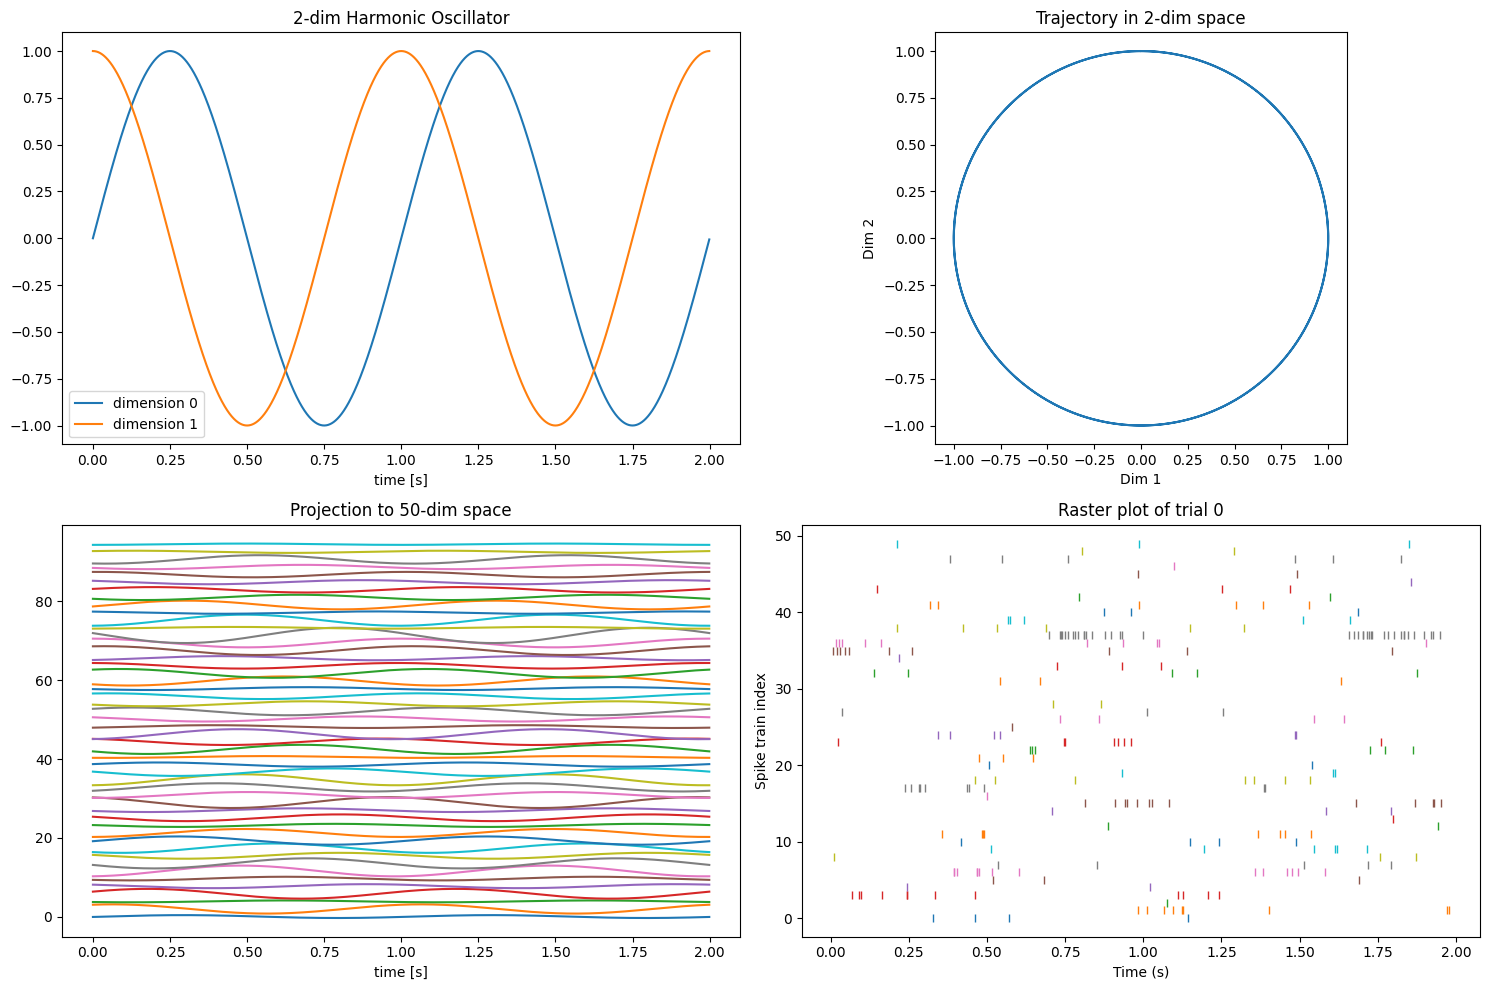

In [6]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title('2-dim Harmonic Oscillator')
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i}')
ax1.legend()

ax2.set_title('Trajectory in 2-dim space')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('time [s]')
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [22]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [23]:
gpfa_2dim.fit(spiketrains_oscillator[:num_trials//2])
print(gpfa_2dim.params_estimated.keys())

Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


In [37]:
gpfa_2dim.params_estimated['C'].shape

(50, 2)

In [38]:
'''
Then we transform the spike trains from the remaining half of the trials 
into trajectories in the latent variable space, using the transform() method.
'''
trajectories = gpfa_2dim.transform(spiketrains_oscillator[num_trials//2:])

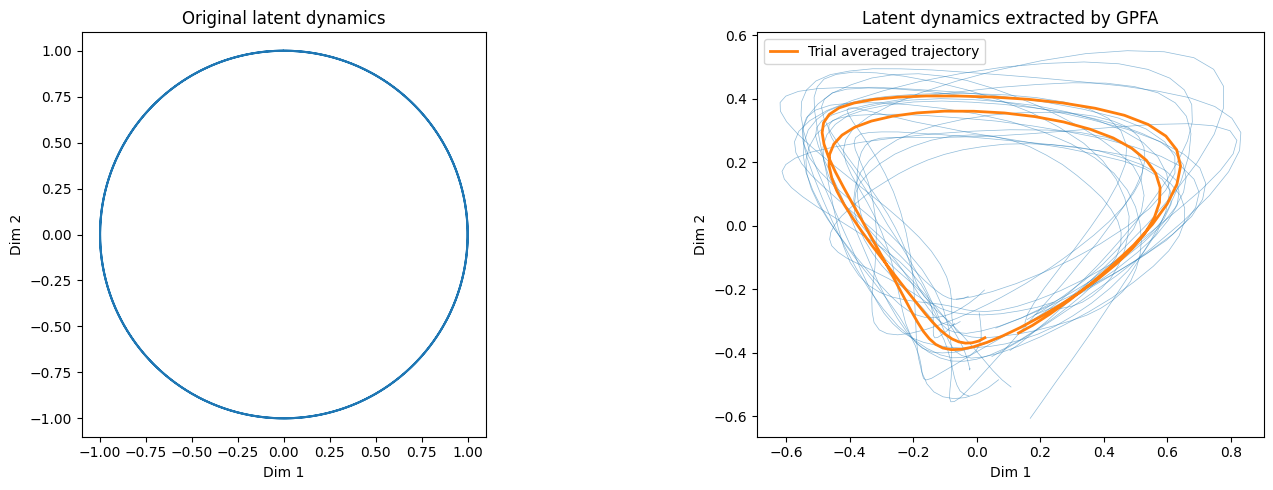

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
ax1.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()

Initializing parameters using factor analysis...

Fitting GPFA model...


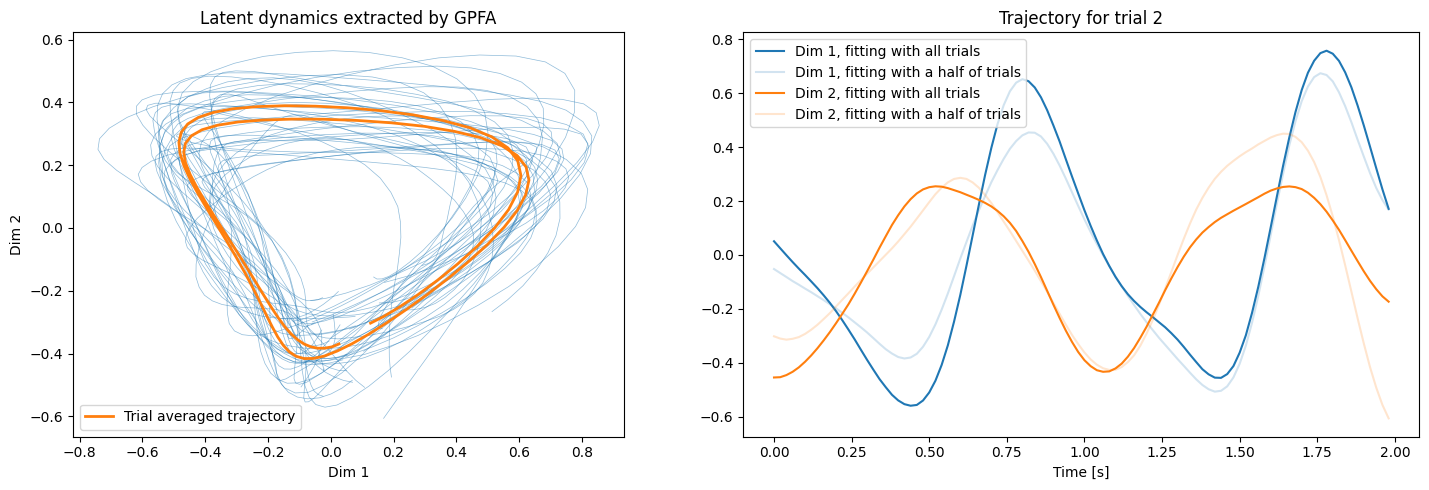

In [41]:
# here we just reuse the existing instance of the GPFA() class as we use the same fitting parameters as before
trajectories_all = gpfa_2dim.fit_transform(spiketrains_oscillator)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Latent dynamics extracted by GPFA')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
for single_trial_trajectory in trajectories_all:
    ax1.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
average_trajectory = np.mean(trajectories_all, axis=0)
ax1.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax1.legend()

trial_to_plot = 0
ax2.set_title(f'Trajectory for trial {trial_to_plot}')
ax2.set_xlabel('Time [s]')
times_trajectory = np.arange(len(trajectories_all[trial_to_plot][0])) * bin_size.rescale('s')
ax2.plot(times_trajectory, trajectories_all[0][0], c='C0', label="Dim 1, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][0], c='C0', alpha=0.2, label="Dim 1, fitting with a half of trials")
ax2.plot(times_trajectory, trajectories_all[0][1], c='C1', label="Dim 2, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][1], c='C1', alpha=0.2, label="Dim 2, fitting with a half of trials")
ax2.legend()

plt.tight_layout()
plt.show()

### 3D Lorentz system

In [29]:
# set parameters for the integration of the Lorentz attractor
timestep = 1 * pq.ms
transient_duration = 10 * pq.s
trial_duration = 30 * pq.s
num_steps_transient = int((transient_duration.rescale('ms')/timestep).magnitude)
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data
num_trials = 20
num_spiketrains = 50

# calculate the oscillator
times, lorentz_trajectory_3dim = integrated_lorenz(
    timestep, num_steps=num_steps_transient+num_steps, x0=0, y0=1, z0=1.25)
times = (times - transient_duration).rescale('s').magnitude
times_trial = times[num_steps_transient:]

# random projection
lorentz_trajectory_Ndim = random_projection(
    lorentz_trajectory_3dim[:, num_steps_transient:], embedding_dimension=num_spiketrains)

# calculate instantaneous rate
normed_traj = lorentz_trajectory_Ndim / lorentz_trajectory_Ndim.max()
instantaneous_rates_lorentz = np.power(max_rate.magnitude, normed_traj)

# generate spiketrains
spiketrains_lorentz = generate_spiketrains(
    instantaneous_rates_lorentz, num_trials, timestep)

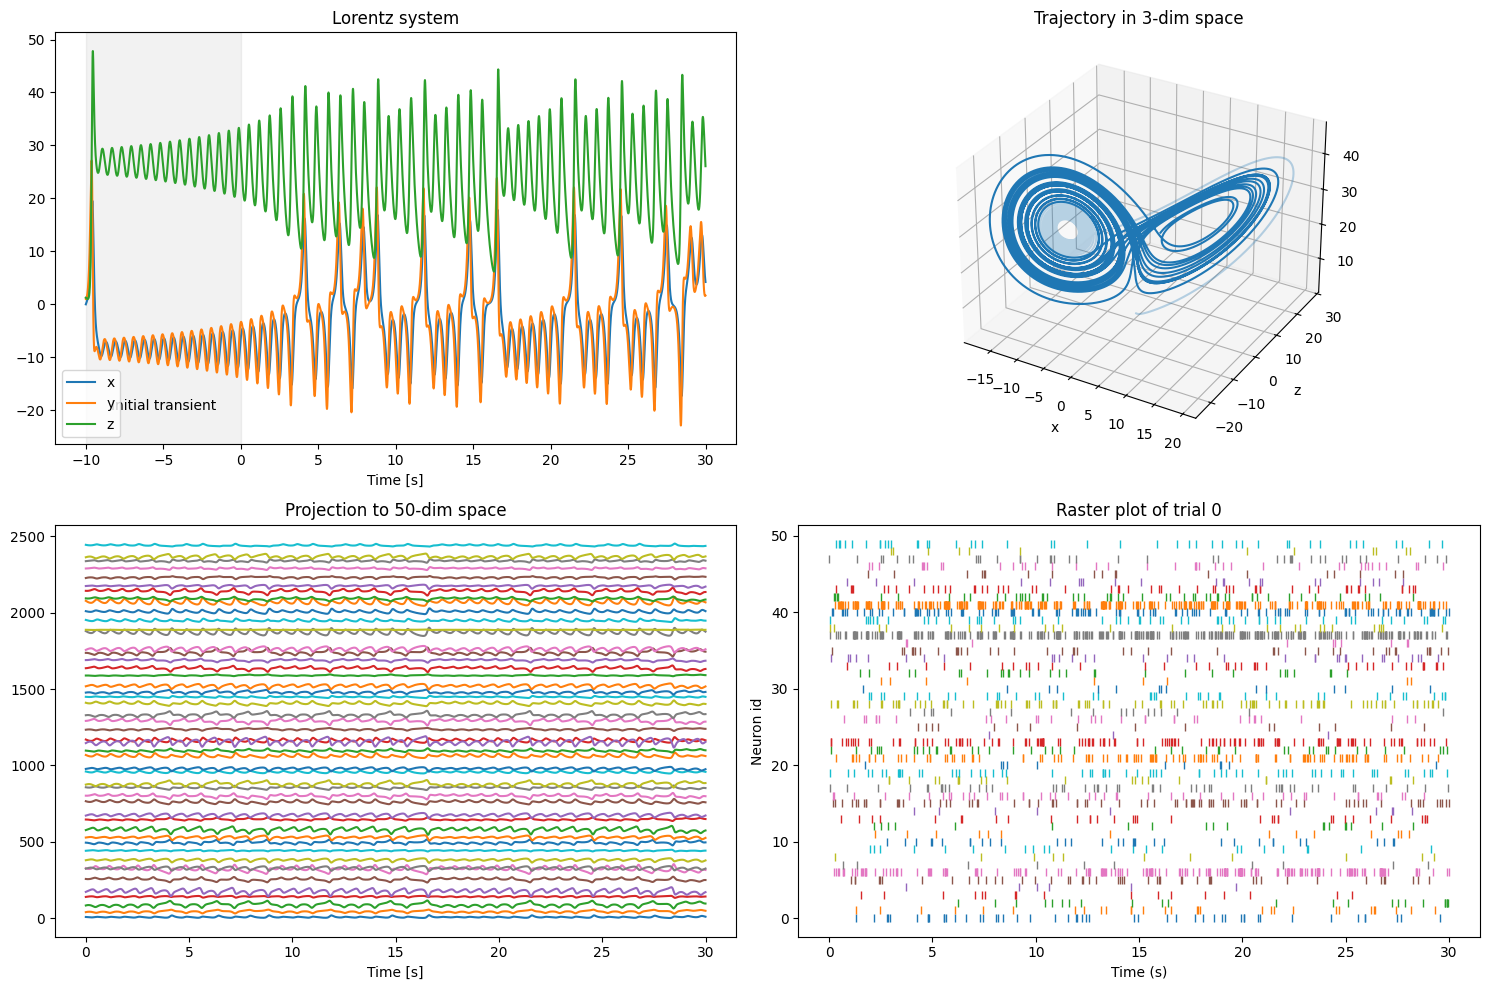

In [30]:
from mpl_toolkits.mplot3d import Axes3D


f = plt.figure(figsize=(15, 10))
ax1 = f.add_subplot(2, 2, 1)
ax2 = f.add_subplot(2, 2, 2, projection='3d')
ax3 = f.add_subplot(2, 2, 3)
ax4 = f.add_subplot(2, 2, 4)

ax1.set_title('Lorentz system')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim):
    ax1.plot(times, x, label=labels[i])
ax1.axvspan(-transient_duration.rescale('s').magnitude, 0, color='gray', alpha=0.1)
ax1.text(-5, -20, 'Initial transient', ha='center')
ax1.legend()

ax2.set_title(f'Trajectory in 3-dim space')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_ylabel('z')
ax2.plot(lorentz_trajectory_3dim[0, :num_steps_transient],
         lorentz_trajectory_3dim[1, :num_steps_transient],
         lorentz_trajectory_3dim[2, :num_steps_transient], c='C0', alpha=0.3)
ax2.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:], c='C0')

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('Time [s]')
y_offset = lorentz_trajectory_Ndim.std() * 3
for i, y in enumerate(lorentz_trajectory_Ndim):
    ax3.plot(times_trial, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Neuron id')
for i, spiketrain in enumerate(spiketrains_lorentz[trial_to_plot]):
    ax4.plot(spiketrain, np.ones(len(spiketrain)) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [31]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 3

gpfa_3dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)
trajectories = gpfa_3dim.fit_transform(spiketrains_lorentz)

Initializing parameters using factor analysis...

Fitting GPFA model...


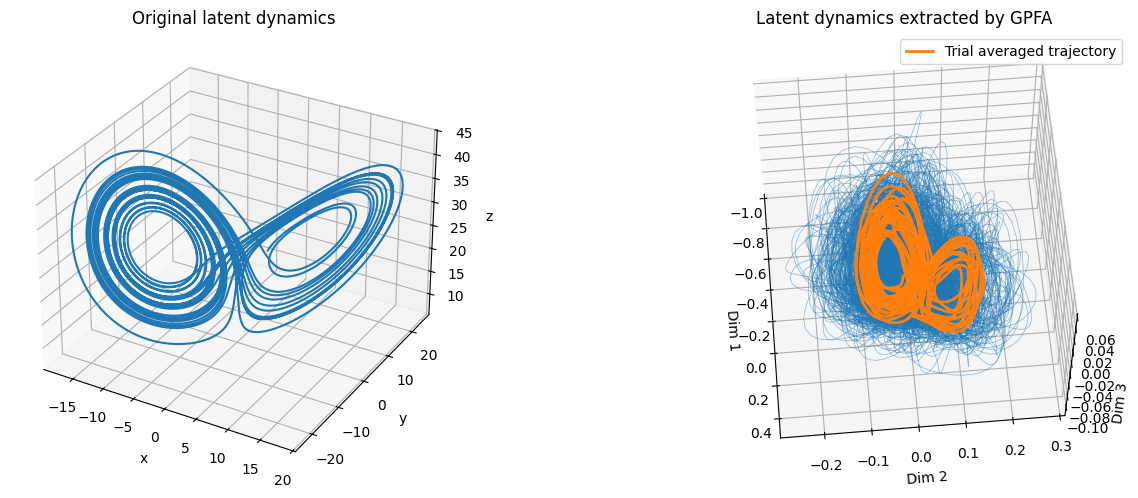

In [32]:
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax2 = f.add_subplot(1, 2, 2, projection='3d')

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2],
             lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], average_trajectory[2], lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()
ax2.view_init(azim=-5, elev=60)  # an optimal viewing angle for the trajectory extracted from our fixed spike trains

plt.tight_layout()
plt.show()

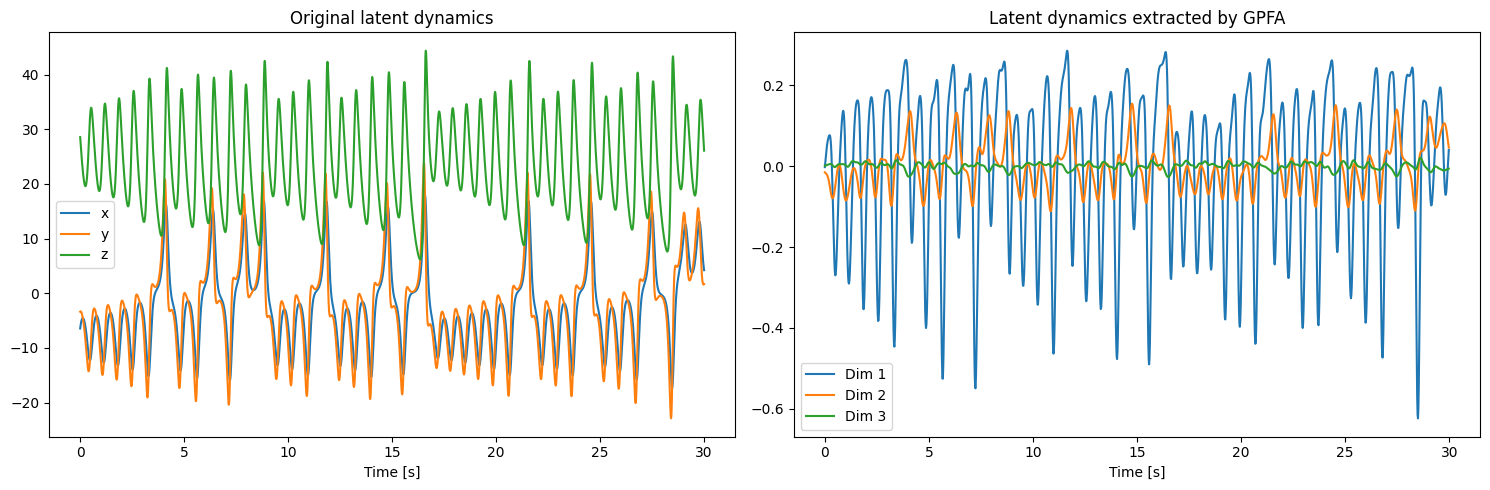

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim[:, num_steps_transient:]):
    ax1.plot(times_trial, x, label=labels[i])
ax1.legend()

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Time [s]')
for i, x in enumerate(average_trajectory):
    ax2.plot(np.arange(len(x))*0.02, x, label=f'Dim {i+1}')
ax2.legend()

plt.tight_layout()
plt.show()